# 03. Machine Learning for music playlists: Preprocessing Data

This is the third post in a series of posts devoted to analysis of iTunes music library using Scikit-Learn tools.   
This notebook covers steps necessary to preprocess data to use it as input for Scikit-learn machine learning algorithms. 

Previous posts cover the following steps:
* [00_Summary](http://localhost:8888/notebooks/00_Summary.ipynb) — Summary of this analysis, its goals and methods, installation notes.
* [01_Data_preparation](http://localhost:8888/notebooks/01_Data_preparation.ipynb) — Data gathering and cleaning.
* [02_Data_visualisation](http://localhost:8888/notebooks/02_Data_Visualisation.ipynb) — Visualisation and overview of data.

As a result of previous manipulations I have two databases (DBs): 
* training DB contains 88 tracks labeled with one of the three classes: "ballet", "cycling", "yoga";
* test DB contains 444 non-labeled tracks. 

As a shortcut, I import module "data_processing" with functions from the [01_Data_preparation](http://localhost:8888/notebooks/01_Data_preparation.ipynb) notebook.  

I start with importing the modules required in the following notebook.

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd
import numpy as np
from sqlitedict import SqliteDict

# import my module from the previous notebook
import data_processing as prs

# set seaborn plot defaults
import seaborn as sns; 
sns.set(palette="husl")
sns.set_context("notebook")
sns.set_style("ticks")

# format floating point numbers
# within pandas data structures
pd.set_option('float_format', '{:.2f}'.format)

#### Read in datasets

In [3]:
# train DB
train_db = SqliteDict('./labeled_tracks', autocommit=True)

# create a df with training data
train_df = prs.read_db_in_pandas(train_db)

train_df.sample(3)

,song_title,acousticness,artist,category,danceability,energy,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,valence
13,Climbing Walls,0.00,Strange Talk,cycling,0.59,0.94,0.28,7,-3.59,1,0.06,140.01,4,0.86
57,Skinny Love,0.96,Birdy,ballet,0.46,0.13,0.00,4,-13.32,1,0.11,78.50,4,0.13
14,Cross Hands,0.81,Piano Interrupted,ballet,0.73,0.21,0.90,8,-21.46,1,0.04,127.99,4,0.07


In [4]:
# test DB
test_db = SqliteDict('./itunes_tracks',
                     autocommit=True)
# create a df with test data
test_df = prs.read_db_in_pandas(test_db)

test_df.sample(3)

,song_title,acousticness,artist,danceability,energy,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,valence
314,Slow,0.76,Rumer,0.52,0.34,0.00,10,-8.00,0,0.03,137.05,4,0.27
317,Smalltown Boy,0.40,Bronski Beat,0.44,0.44,0.00,10,-9.42,1,0.03,135.59,4,0.64
72,Dour Percentage,0.26,of Montreal,0.62,0.82,0.00,0,-3.82,1,0.03,111.00,4,0.71


In this post, I will go through the following steps:
1. Data transformation to numerical (Numpy) arrays;
2. Standardisation of the features;
3. Dimensionality reduction.

## Transform sets
To work with scikit-learn library, both datasets need to be shaped a bit.
Most machine learning algorithms implemented in scikit-learn expect a numpy array as input. The expected shape of the input is (n_samples, n_features). This applies both to the training and test datasets.
n_samples: the number of samples; each sample is an item to be classified. In our case this would be a track.
n_features: the number of features or distinct traits that can be used to describe each item in a quantitative manner. In our case these are the track attributes. Features like "song_title" and "artist" are not quantitative and are not relevant for the classification task, that's why I exclude these from both inputs.

I transform both dataframes to numerical (Numpy) arrays. I copy the original sets and apply the required changes to copies not to loose any data.

### — Training set —
I start with the training set. "category" column in the training set has to be transformed into numerical format to be processed by scikit-learn algorithms as target data (labels). "Typical" machine learning algorithms handle class labels with "no order implied" - unless a ranking classifier (e.g., SVM-rank) is used. Thus, it is save to use a simple set-item-enumeration to convert the class labels from a string representation into integers.

I use LabelEncoder scikit-learn function, which encodes labels with values between 0 and n_classes-1. 

In [5]:
# transform target classes to numerical labels
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

# list the three categories
categories = list(pd.unique(train_df.category.ravel()))
le.fit(categories)

# list target classes
list(le.classes_)

[u'ballet', u'cycling', u'yoga']

In [6]:
# create an array with target labels
target = le.transform(train_df['category'])
target

array([1, 2, 2, 2, 1, 0, 2, 0, 1, 2, 1, 2, 2, 1, 0, 0, 2, 1, 0, 1, 0, 2, 1,
       2, 1, 1, 1, 2, 0, 1, 1, 2, 0, 0, 0, 0, 1, 2, 0, 1, 0, 2, 2, 0, 0, 2,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 2, 0, 2, 0, 0, 1, 1, 0, 0, 2, 2,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 2, 1, 1, 0, 2, 2])

I convert the DF to a numerical Numpy array so that each track (observation) forms a row, and the track attributes (features) form columns.

In [7]:
# columns with numerical values
cols = train_df.select_dtypes(exclude=[object]).columns

# convert df to a numerical (Numpy) array
train_data = np.nan_to_num(train_df[cols].values)

# review
train_data.shape

(88, 11)

### — Test set —

In [8]:
# columns with numerical values
cols = test_df.select_dtypes(exclude=[object]).columns

# convert df to a numerical (Numpy) array
test_data = np.nan_to_num(test_df[cols].values)

# review
test_data.shape

(444, 11)

## Data Standardization
It is necessary to perform standardization of features in both sets. This step is required because when training the models estimators might behave badly if the individual features do not more or less look like standard normally distributed data: Gaussian with zero mean and unit variance. If a feature has a variance that is orders of magnitude larger that others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected. In our case "tempo" attribute varies from 46.22 to 194.90, whereas "loudness" is in range [-35.89, -1.84], and most features are whithin [0, 1] boundaries. The estimator will be unable to learn from other features correctly as expected.   
The only family of algorithms that is scale-invariant are tree-based methods.
 
For the majority of algorithms it is essential to rescale the inputs so that their variability reflects their importance, or at least is not in inverse relation to their importance. For lack of better prior information, I standardize each input to the same standard deviation. 

I use scikit-learn module StandardScaler for this purpose. Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. Mean and standard deviation are then stored to be used on test data using the transform method.
#### — Training data —

In [9]:
from sklearn import preprocessing

# train the model
std_scale = preprocessing.StandardScaler().fit(train_data)
# perform standardization of features in the training set
train_std = std_scale.transform(train_data)

In [13]:
# print the result of feature standardization
print "Mean, standard deviation, and min/max values after standardization:" 
pd.DataFrame(train_std, 
             columns=cols).describe().loc[
                            ['mean', 'std', 'min', 'max'], :]

Mean, standard deviation, and min/max values after standardization:


,acousticness,danceability,energy,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,valence
mean,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00
std,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01
min,-1.22,-2.40,-1.54,-0.91,-1.66,-2.61,-1.17,-1.04,-2.43,-3.49,-1.22
max,1.19,2.89,1.69,1.44,1.55,1.40,0.85,4.73,2.17,1.74,2.12


In [15]:
# make a DF with trained StandardScaler() parameters
params = pd.DataFrame({'mean' : std_scale.mean_, 
                       'std': std_scale.std_}, 
                      index=cols).T

print "StandardScaler parameters: "
params

StandardScaler parameters: 


,acousticness,danceability,energy,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,valence
mean,0.50,0.47,0.48,0.38,5.68,-12.49,0.58,0.05,122.29,3.67,0.37
std,0.41,0.17,0.30,0.42,3.42,6.79,0.49,0.02,31.24,0.76,0.28


#### — Test data —
I use the above parameters to transform unlabeled data, or test data.
It's essential to apply the same parameters and not to retrain the model on the test set. Why? Because you pretend that the test data is "new, unseen data." In a real application, new, unseen data could be 1 data point, or hundreds or thousands of data points (how do you standardize if you have only 1 data point? That's why you need the training data parameters; by using the test set, you basically simulate this process). Also you expect the test data to be from the same distribution as the training data; thus, if both training and test sets are sufficiently large enough, your parameters would be the same anyway.

In [16]:
# perform standardization of features of test data
test_std = std_scale.transform(test_data)

In [18]:
# print the result of feature standardization
print "Mean, standard deviation, and min/max values after standardization:" 
pd.DataFrame(test_std, 
             columns=cols).describe().loc[
                            ['mean', 'std', 'min', 'max'], :]

Mean, standard deviation, and min/max values after standardization:


,acousticness,danceability,energy,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,valence
mean,-0.53,0.73,0.49,-0.29,-0.13,0.48,-0.08,0.64,-0.11,0.36,0.45
std,0.71,0.89,0.71,0.81,1.08,0.62,1.01,3.34,0.81,0.40,0.88
min,-1.22,-1.99,-1.49,-0.91,-1.66,-2.46,-1.17,-2.19,-2.23,-3.49,-1.22
max,1.18,2.79,1.69,1.37,1.55,1.68,0.85,32.72,2.55,1.74,2.14


#### Plot features: before and after standardization

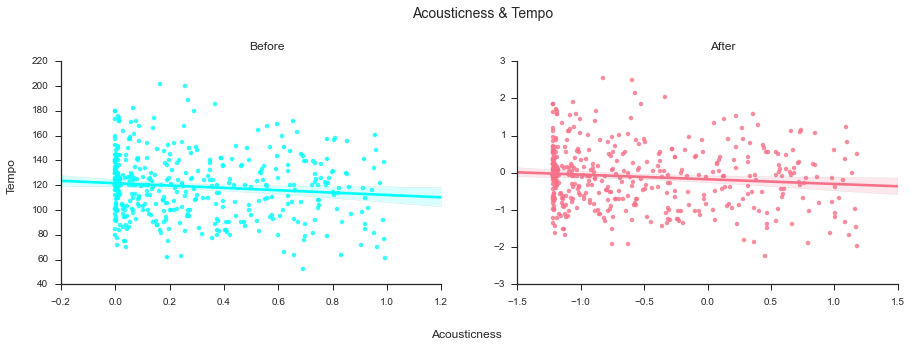

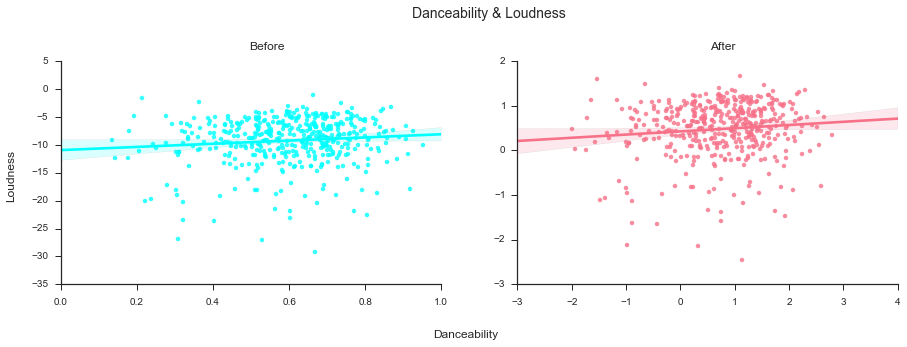

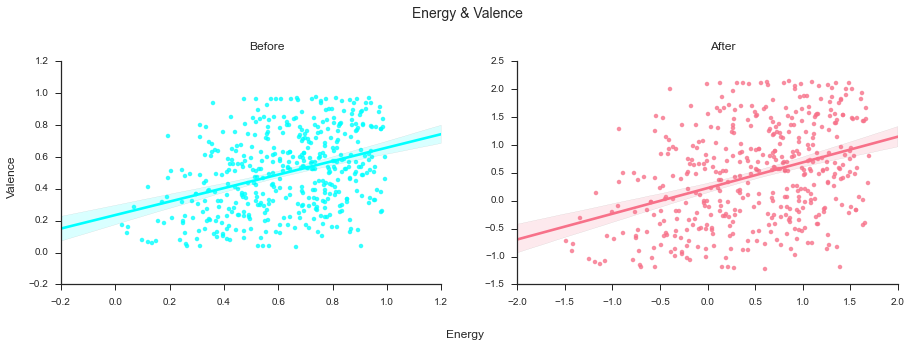

In [19]:
def plot_standard_features(ind1, ind2, labelx, labely):
    """Create two scatterplots with feature values before
    and after standardization.
    """
    fig = plt.figure(figsize=(15,4))
    
    # Add title
    
    fig.text(0.45, 1.05, (labelx + ' & ' + labely),
            size=14)
    
    # Set labels
    
    fig.text(0.3, 0.95, 'Before',
            ha='left', va='center')
    fig.text(0.75, 0.95, 'After',
            ha='right', va='center')
    fig.text(0.5, -0.05, labelx, 
         ha='center', va='center')
    fig.text(0.08, 0.5, labely, ha='center', 
         va='center', rotation='vertical')
    
    # make a scatterplot
    # before standardization
    plt.subplot(121)
    sns.regplot(x=test_data[:,ind1], 
                y=test_data[:,ind2], 
                data=test_data, 
                color='aqua')

    # after standardization
    plt.subplot(122)
    sns.regplot(x=test_std[:,ind1], 
                y=test_std[:,ind2], 
                data=test_std)
    
    # remove the top and right spines from plots
    sns.despine()

plot_standard_features(0, 8, 'Acousticness', 'Tempo')
plot_standard_features(1, 5, 'Danceability', 'Loudness')
plot_standard_features(2, 10, 'Energy', 'Valence')

I made these plots to confirm that the shape of scatter plots before and after transformation remains the same. 

## Dimensionality reduction
The significance of feature standardization is seen when performing [Principal Component Analysis (PCA)](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to reduce the dimensionality. PCA algorithm keeps only the most significant singular vectors to project the
data to a lower dimensional space. I perform a PCA on the standardized and the non-standardized datasets to transform the dataset onto a 2-dimensional feature subspace. 

In [205]:
from sklearn.decomposition import PCA

# non-standardized data
pca = PCA(n_components=2).fit(train_data)
X_train = pca.transform(train_data)
X_test = pca.transform(test_data)

# standadrized data
pca_std = PCA(n_components=2).fit(train_std)
X_train_std = pca_std.transform(train_std)
X_test_std = pca_std.transform(test_std)

# print the result
print "Training data"
print "Original shape:", train_data.shape
print "Reduced shape:", X_train.shape
print "\nTest data"
print "Original shape:", test_data.shape
print "Reduced shape:", X_test.shape

Training data
Original shape: (88, 11)
Reduced shape: (88, 2)

Test data
Original shape: (444, 11)
Reduced shape: (444, 2)


In [206]:
print "Non-standardized data"
print("Meaning of the 2 components:")
for component in pca.components_:
    print(" + ".join("%.3f x %s" % (value, name)
                     for value, name in zip(component,
                                            train_matrix.columns)))
    
print "\nStandardized data"
print("Meaning of the 2 components:")
for component in pca_std.components_:
    print(" + ".join("%.3f x %s" % (value, name)
                     for value, name in zip(component,
                                            train_matrix.columns)))

Non-standardized data
Meaning of the 2 components:
-0.003 x acousticness + 0.001 x danceability + 0.004 x energy + -0.002 x instrumentalness + -0.004 x key + 0.078 x loudness + 0.002 x mode + 0.000 x speechiness + 0.997 x tempo + 0.003 x time_signature + 0.003 x valence
-0.045 x acousticness + 0.011 x danceability + 0.036 x energy + -0.053 x instrumentalness + -0.120 x key + 0.986 x loudness + -0.001 x mode + 0.001 x speechiness + -0.078 x tempo + 0.037 x time_signature + 0.022 x valence

Standardized data
Meaning of the 2 components:
-0.403 x acousticness + 0.273 x danceability + 0.438 x energy + -0.365 x instrumentalness + -0.079 x key + 0.434 x loudness + 0.061 x mode + 0.161 x speechiness + 0.199 x tempo + 0.227 x time_signature + 0.348 x valence
-0.033 x acousticness + 0.279 x danceability + 0.010 x energy + 0.065 x instrumentalness + 0.491 x key + 0.062 x loudness + -0.577 x mode + -0.498 x speechiness + 0.030 x tempo + -0.161 x time_signature + 0.254 x valence


TODO: summary

### Plot features in 2D
Next I visualise how the new feature subspace looks like. Class labels are not considered in a PCA but I will add them in the plot for clarity.

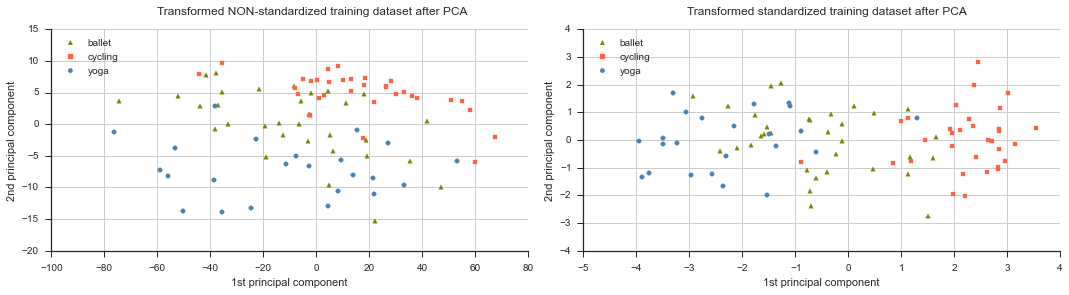

In [265]:
fig, (ax1, ax2) = plt.subplots(ncols=2, 
                               figsize=(15,4))

fig.text(0.15, 1, 
         'Transformed NON-standardized training dataset after PCA',
        ha='left', va='center')
fig.text(0.9, 1, 
         'Transformed standardized training dataset after PCA',
         ha='right', va='center')

for l,c,m in zip(range(0,3), 
                 ('olive', 'tomato', 'steelblue'), 
                 ('^', 's', 'o')):
    ax1.scatter(X_train[target==l, 0], 
                X_train[target==l, 1],
                color=c,
                label=list(le.classes_)[l], # add class labels from the LabelEncoder()
                marker=m
                )

for l,c,m in zip(range(0,3), 
                 ('olive', 'tomato', 'steelblue'), 
                 ('^', 's', 'o')):
    ax2.scatter(X_train_std[target==l, 0], 
                X_train_std[target==l, 1],
                color=c,
                label=list(le.classes_)[l],
                marker=m
                )

for ax in (ax1, ax2):

    ax.set_xlabel('1st principal component')
    ax.set_ylabel('2nd principal component')
    ax.legend(loc='upper left')
    ax.grid()

sns.despine()
plt.tight_layout()
plt.show()  

In [20]:
from sklearn.decomposition import PCA

# non-standardized data
pca_3d = PCA(n_components=3).fit(train_data)
X_train_3d = pca_3d.transform(train_data)
X_test_3d = pca_3d.transform(test_data)

# standadrized data
pca_std_3d = PCA(n_components=3).fit(train_std)
X_train_std_3d = pca_std_3d.transform(train_std)
X_test_std_3d = pca_std_3d.transform(test_std)

# print the result
print "Training data"
print "Original shape:", train_data.shape
print "Reduced shape:", X_train_3d.shape
print "\nTest data"
print "Original shape:", test_data.shape
print "Reduced shape:", X_test_3d.shape

Training data
Original shape: (88, 11)
Reduced shape: (88, 3)

Test data
Original shape: (444, 11)
Reduced shape: (444, 3)


/Users/olgamedennikova/projects/data1/env/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


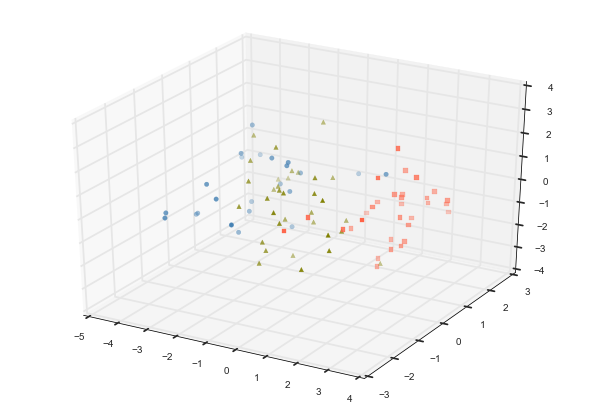

In [21]:
from IPython.html.widgets import interactive, fixed
from mpl_toolkits.mplot3d import Axes3D

# def plot_3d_scatter(A, elevation=30, azimuth=120):
#     """ Create 3D scatterplot """
    
#     maxpts=1000
#     fig = plt.figure(1, figsize=(9, 9))
#     ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=elevation, azim=azimuth)
#     ax.set_xlabel('component 0')
#     ax.set_ylabel('component 1')
#     ax.set_zlabel('component 2')

#     # plot subset of points
#     rndpts = np.sort(np.random.choice(A.shape[0], min(maxpts,A.shape[0]), replace=False))
#     coloridx = np.unique(A.iloc[rndpts]['class'], return_inverse=True)
#     colors = coloridx[1] / len(coloridx[0])   
    
#     sp = ax.scatter(A.iloc[rndpts,0], A.iloc[rndpts,1], A.iloc[rndpts,2]
#                ,c=colors, cmap="jet", marker='o', alpha=0.6
#                ,s=50, linewidths=0.8, edgecolor='#BBBBBB')

#     plt.show()
    
ax = Axes3D(plt.gcf())
for l,c,m in zip(range(0,3), 
             ('olive', 'tomato', 'steelblue'), 
             ('^', 's', 'o')):
    ax.scatter(X_train_std_3d[target==l, 0], 
               X_train_std_3d[target==l, 2],
               X_train_std_3d[target==l, 1],
               zdir='z', s=20,
               depthshade=True,
               color=c,
                label=list(le.classes_)[l], # add class labels from the LabelEncoder()
                marker=m
                )


# ax.scatter(train_std[:, 0], train_std[:, 1], zs=train_std[:, 2], 
#                zdir='z', s=20, c='b', depthshade=True)

PCA algorithm here chooses an “interesting” linear projection of the data. This method can be powerful, but often misses important non-linear structure in the data. I'd say that for this dataset this is not the best algorithm to visualize the three classes. 
TODO: summary